## Multi-threading case

In [1]:
!pip3 install selenium==4.6.0
!pip3 install webdriver-manager==3.8.5
!pip3 install diagrams==0.23.1
!pip3 install retry==0.9.2
!pip3 install loguru==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 27.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: selenium
    Found existing installation: selenium 4.7.2
    Uninstalling selenium-4.7.2:
      Successfully uninstalled selenium-4.7.2
  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 2.4 MB/s eta 0:00:00
  Using cached charset_normalizer-2.1.1-py3-none-any.whl (39 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 33.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 1.8 MB/s eta 0:00:00


In [3]:
import os
import threading
import time

from selenium import webdriver
from selenium.webdriver.common.by import By

from webdriver_manager.chrome import ChromeDriverManager
from webdriver_manager.core.utils import ChromeType
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service

from IPython import display
from IPython.display import Image
from base64 import b64decode, urlsafe_b64decode, decodebytes

from retry import retry
from loguru import logger
from timeit import default_timer as timer
from datetime import timedelta

In [5]:
def saveBase64Image(img_data, filename):
    with open(f"src/{filename}", "wb") as fh:
        fh.write(b64decode(img_data))

In [6]:
logger.add("file_{time}.log", level='DEBUG')

1

In [ ]:
chrome_service = Service(ChromeDriverManager().install())
logger.info("Install chrome driver") 

In [8]:
# Get environment variables
IS_GITHUB_ACTION = os.getenv('IS_GITHUB_ACTION')
logger.info("Set github action env")

2022-12-18 09:11:37.610 | INFO     | __main__:<module>:3 - Set github action env


In [9]:
chrome_options = Options()
if IS_GITHUB_ACTION:
    options = [
        "--headless",
        "--disable-gpu",
        "--window-size=1920,1080",
        "--ignore-certificate-errors",
        "--disable-extensions",
        "--no-sandbox",
        "--disable-dev-shm-usage"
    ]
    user_agent = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.50 Safari/537.36'    
    chrome_options.add_argument('user-agent={0}'.format(user_agent))
    for option in options:
        chrome_options.add_argument(option)

logger.info("Set chrome driver options")

2022-12-18 09:11:39.460 | INFO     | __main__:<module>:17 - Set chrome driver options


In [10]:
logger.info("Run chrome driver")
browser = webdriver.Chrome(service=chrome_service, options=chrome_options)
browser.set_window_size(1920, 1080)
browser.get('https://www.gotokyo.org/kr/destinations/index.html')
logger.debug("Load main page done url {url}", url='https://www.gotokyo.org/kr/destinations/index.html')

2022-12-18 09:11:42.395 | INFO     | __main__:<module>:1 - Run chrome driver
2022-12-18 09:12:27.055 | DEBUG    | __main__:<module>:5 - Load main page done url https://www.gotokyo.org/kr/destinations/index.html


In [ ]:
logger.info("Crawl place list")
placeList = browser.find_elements(By.CSS_SELECTOR, '#tmp_explore_tokyo > div > ul.mod_figure_list > li');
logger.debug("Place list len: {place_len}", place_len = len(placeList))
display.Image(b64decode(placeList[0].screenshot_as_base64))

# saveBase64Image(placeList[0].screenshot_as_base64, "test.png")

2022-12-18 10:23:59.292 | INFO     | __main__:<module>:1 - Crawl place list


In [12]:
def getAreaListFromPlace(place):
    try:
        return [(area.text, area.get_attribute("href")) for area in place.find_elements(By.CSS_SELECTOR, "a + ul > li > a")]
    except Exception as e:
        logger.error("Cannot get place data, e: {err}", place=place, err=e)
    return []


In [13]:
logger.info("Crawl place's area data")
placeAndUrlList = [(place.find_element(By.TAG_NAME, 'a').text, 
                    place.find_element(By.TAG_NAME, 'a').get_attribute('href'),
                    getAreaListFromPlace(place)
                   ) for place in placeList]
logger.debug("Place's area data: {data}", data=placeAndUrlList)
# placeAndUrlList

2022-12-18 10:03:38.425 | INFO     | __main__:<module>:1 - Crawl place's area data


WebDriverException: Message: disconnected: Unable to receive message from renderer
  (failed to check if window was closed: timeout: Timed out receiving message from renderer: 600.000)
  (Session info: chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x00000001024b6f38 chromedriver + 4910904
1   chromedriver                        0x0000000102436a03 chromedriver + 4385283
2   chromedriver                        0x000000010207b747 chromedriver + 472903
3   chromedriver                        0x0000000102064427 chromedriver + 377895
4   chromedriver                        0x00000001020640a0 chromedriver + 376992
5   chromedriver                        0x00000001020627f2 chromedriver + 370674
6   chromedriver                        0x0000000102062bb4 chromedriver + 371636
7   chromedriver                        0x00000001020613d1 chromedriver + 365521
8   chromedriver                        0x00000001020728d9 chromedriver + 436441
9   chromedriver                        0x0000000102060d16 chromedriver + 363798
10  chromedriver                        0x0000000102063b46 chromedriver + 375622
11  chromedriver                        0x00000001020627f2 chromedriver + 370674
12  chromedriver                        0x0000000102062bb4 chromedriver + 371636
13  chromedriver                        0x00000001020613d1 chromedriver + 365521
14  chromedriver                        0x000000010206f010 chromedriver + 421904
15  chromedriver                        0x0000000102060d16 chromedriver + 363798
16  chromedriver                        0x0000000102063b46 chromedriver + 375622
17  chromedriver                        0x00000001020627f2 chromedriver + 370674
18  chromedriver                        0x0000000102062bb4 chromedriver + 371636
19  chromedriver                        0x00000001020613d1 chromedriver + 365521
20  chromedriver                        0x000000010206a8af chromedriver + 403631
21  chromedriver                        0x0000000102060d16 chromedriver + 363798
22  chromedriver                        0x0000000102063b46 chromedriver + 375622
23  chromedriver                        0x00000001020627f2 chromedriver + 370674
24  chromedriver                        0x0000000102062bb4 chromedriver + 371636
25  chromedriver                        0x00000001020613d1 chromedriver + 365521
26  chromedriver                        0x0000000102059076 chromedriver + 331894
27  chromedriver                        0x0000000102060d16 chromedriver + 363798
28  chromedriver                        0x0000000102063b46 chromedriver + 375622
29  chromedriver                        0x00000001020627f2 chromedriver + 370674
30  chromedriver                        0x0000000102062bb4 chromedriver + 371636
31  chromedriver                        0x00000001020613d1 chromedriver + 365521
32  chromedriver                        0x00000001020728d9 chromedriver + 436441
33  chromedriver                        0x0000000102060d16 chromedriver + 363798
34  chromedriver                        0x0000000102063b46 chromedriver + 375622
35  chromedriver                        0x00000001020627f2 chromedriver + 370674
36  chromedriver                        0x0000000102062bb4 chromedriver + 371636
37  chromedriver                        0x00000001020613d1 chromedriver + 365521
38  chromedriver                        0x000000010206f010 chromedriver + 421904
39  chromedriver                        0x0000000102060d16 chromedriver + 363798
40  chromedriver                        0x0000000102063b46 chromedriver + 375622
41  chromedriver                        0x00000001020627f2 chromedriver + 370674
42  chromedriver                        0x0000000102062bb4 chromedriver + 371636
43  chromedriver                        0x00000001020613d1 chromedriver + 365521
44  chromedriver                        0x000000010206a8af chromedriver + 403631
45  chromedriver                        0x0000000102060d16 chromedriver + 363798
46  chromedriver                        0x0000000102060264 chromedriver + 361060
47  chromedriver                        0x0000000102060390 chromedriver + 361360
48  chromedriver                        0x00000001020606b9 chromedriver + 362169
49  chromedriver                        0x000000010206066f chromedriver + 362095
50  chromedriver                        0x000000010207d369 chromedriver + 480105
51  chromedriver                        0x00000001021007b1 chromedriver + 1017777
52  chromedriver                        0x00000001020e5ee3 chromedriver + 909027
53  chromedriver                        0x00000001020b030c chromedriver + 688908
54  chromedriver                        0x00000001020b188e chromedriver + 694414
55  chromedriver                        0x00000001024841de chromedriver + 4702686
56  chromedriver                        0x0000000102488b19 chromedriver + 4721433
57  chromedriver                        0x000000010249028e chromedriver + 4752014
58  chromedriver                        0x000000010248991a chromedriver + 4725018
59  chromedriver                        0x000000010245db02 chromedriver + 4545282
60  chromedriver                        0x00000001024a8888 chromedriver + 4851848
61  chromedriver                        0x00000001024a8a05 chromedriver + 4852229
62  chromedriver                        0x00000001024bee5f chromedriver + 4943455
63  libsystem_pthread.dylib             0x00007ff8043dd4e1 _pthread_start + 125
64  libsystem_pthread.dylib             0x00007ff8043d8f6b thread_start + 15


In [12]:
logger.info("Close place crawling browser")
browser.close()

2022-12-11 01:38:58.127 | INFO     | __main__:<module>:1 - Close place crawling browser


## Get area's detail info

In [20]:
def getSlideItems(slideItemList):
    logger.debug("Slider item list len {}", len(slideItemList))
    try:
        return [(slideItem.find_element(By.TAG_NAME, 'img').get_attribute('alt'), # tour content name
            slideItem.find_element(By.TAG_NAME, 'img').get_attribute('src'), # tour content img
            slideItem.find_element(By.TAG_NAME, 'a').get_attribute('href') # tour content detail link
            ) for slideItem in slideItemList]
    except Exception as e:
        logger.error("Slider item error {}", e)

In [21]:
@retry(Exception, tries=3, delay=2)
def getSlideList(browser):
    sliderCrawlResult = []
    try:
        logger.info("Remove banner to load slider list")
        browser.execute_script("document.querySelector('div.section_banner_top').remove();document.querySelector('div.left_block').remove();jQuery(window).scroll();")
        logger.info("Banner removed")
    except Exception as e:
        logger.error("Remove banner has an error {}", e)
    logger.info("Crawl slider items")
    sliderCrawlResult = [(
        slider.find_element(By.CSS_SELECTOR, 'div.slider_ttl > h2').text, #title
        getSlideItems([item for item in slider.find_elements(By.CSS_SELECTOR, 'div.slick_slide_item')]) #slider's items
        ) for slider in browser.find_elements(By.CSS_SELECTOR, 'div.section_slider_body')]
    logger.debug("Crawl slider items result {}", sliderCrawlResult)
    if sum([len(sliderItemList[1]) for sliderItemList in sliderCrawlResult]) <= 0:
        logger.info("Slider is empty, raise error");
        raise Exception('Data not found')
    return sliderCrawlResult
    
# getSlideList(browser)

In [22]:
@retry(Exception, tries=3, delay=2)
def initHeadlessBrowser():
    logger.info("Setup headless browser options")
    chrome_options = Options()
    options = [
        "--headless",
        "--disable-gpu",
        "--window-size=1920,1080",
        "--ignore-certificate-errors",
        "--disable-extensions",
        "--no-sandbox",
        "--disable-dev-shm-usage",
        "start-maximized",
        "disable-infobars"
    ]
    user_agent = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.50 Safari/537.36'    
    chrome_options.add_argument('user-agent={0}'.format(user_agent))
    for option in options:
        chrome_options.add_argument(option)
    browser = webdriver.Chrome(service=chrome_service, options=chrome_options)
    browser.set_window_size(1920, 1080)
    return browser

In [23]:
def resizeBrowserHeightAsContentFullHeight(browser):
    logger.info("Update browser's height same as content height")
    requireHeight = browser.execute_script('return document.body.parentNode.scrollHeight')
    logger.debug("Current content height {}", requireHeight)
    browser.set_window_size(1920, requireHeight)
    browser.execute_script("document.querySelector('div.section_banner_top.setheight').style.height = '464px';")
    logger.info("Manually set banner's height")
    time.sleep(2) # Because of pictures load time

In [24]:
def getAreaInfoProcess(areaName, url, queue=None, idx=None):
    logger.debug("Area crawling process start, url: {}", url)
    slidItemList = []
    try:
        browser = initHeadlessBrowser()
        logger.debug("Browser move to url: {}", url)
        browser.get(url)
        resizeBrowserHeightAsContentFullHeight(browser)
        saveBase64Image(browser.find_element(By.CSS_SELECTOR, "div.left_block").screenshot_as_base64, f'{areaName}.png')
        slidItemList = getSlideList(browser)
        logger.info("Get slider item done")
        if queue is not None:
            queue.put((idx, slidItemList))
    except Exception as e:
        logger.error('Cannot get area info data {}', e)
    finally:
        browser.close()
    logger.info("Area crawling browser closed")
    return slidItemList

In [25]:
start = timer()
getAreaInfoProcess('ginza', 'https://www.gotokyo.org/kr/destinations/central-tokyo/ginza/index.html')
end = timer()
logger.debug("Process take time {}", timedelta(seconds=end-start))

2022-12-11 01:46:56.360 | DEBUG    | __main__:getAreaInfoProcess:2 - Area crawling process start, url: https://www.gotokyo.org/kr/destinations/central-tokyo/ginza/index.html
2022-12-11 01:46:56.361 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-11 01:46:57.359 | DEBUG    | __main__:getAreaInfoProcess:6 - Browser move to url: https://www.gotokyo.org/kr/destinations/central-tokyo/ginza/index.html
2022-12-11 01:46:59.430 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-11 01:46:59.443 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 5734
2022-12-11 01:46:59.551 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-11 01:47:02.524 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-11 01:47:02.538 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-11 01:47:0

2022-12-11 01:47:05.644 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-11 01:47:05.699 | INFO     | __main__:getAreaInfoProcess:18 - Area crawling browser closed
2022-12-11 01:47:05.701 | DEBUG    | __main__:<module>:4 - Process take time 0:00:09.338767


## Single thread, Single process

In [ ]:
start = timer()
areaCrawlingResult = []
for place in placeAndUrlList:
    logger.debug("place: {} len: {}", place[0], len(place[2]))
    for area in place[2]:
        logger.debug("area: {} url: {}", area[0], area[1])
        areaCrawlingResult.append(getAreaInfoProcess(area[0], area[1]))
end = timer()
logger.debug("Process take time {}", timedelta(seconds=end-start))

```
2022-12-10 22:26:21.084 | DEBUG    | __main__:<module>:9 - Process take time 0:12:11.764783
```

In [ ]:
areaCrawlingResult

In [ ]:
import json
with open("areaCrawlingResult.json", 'w') as outfile:
    json.dump(areaCrawlingResult, outfile)
    
with open("placeAndUrlList.json", 'w') as outfile:
    json.dump(placeAndUrlList, outfile)

In [ ]:
areaCrawlingResult[0][0]

## Single process, Multi-threading

In [14]:
from queue import Queue

In [15]:
start = timer()
areaCrawlingResult = []
queue = Queue()
idx = 0
for place in placeAndUrlList:
    threadList = []
    logger.debug("place: {} len: {}", place[0], len(place[2]))
    for area in place[2]:
        idx += 1
        logger.debug("area: {} url: {}", area[0], area[1])
        threadList.append(threading.Thread(target=getAreaInfoProcess, args=[area[0], area[1], queue, idx]))
        
    [thread.start() for thread in threadList]
    [thread.join() for thread in threadList]
    
    while not queue.empty():
        areaCrawlingResult.append(queue.get())

end = timer()
logger.debug("Process take time {}", timedelta(seconds=end-start))

NameError: name 'placeAndUrlList' is not defined

```
2022-12-10 22:51:23.946 | DEBUG    | __main__:<module>:14 - Process take time 0:02:17.029693
```

In [27]:
areaCrawlingResult

[(5,
  [('종교적인 장소',
    [('쓰키지 혼간지(본원사) 절',
      'https://www.gotokyo.org/en/spot/12/images/4403_1_670x450.jpg',
      'https://www.gotokyo.org/kr/spot/12/index.html')]),
   ('시장',
    [('쓰키지 장외시장에 ‘쓰키지 우오가시’ 오픈!',
      'https://www.gotokyo.org/en/new-and-now/new-and-trending/181228/images/181228_thum_400.jpg',
      'https://www.gotokyo.org/kr/new-and-now/new-and-trending/181228/topics.html'),
     ('말차와 센차를 간편하고 세련되게 즐기는 카페&스탠드',
      'https://www.gotokyo.org/en/new-and-now/new-and-trending/190415/images/190415_thum_400.jpg',
      'https://www.gotokyo.org/kr/new-and-now/new-and-trending/190415/topics.html'),
     ('쓰키지 장외시장',
      'https://www.gotokyo.org/kr/spot/65/images/4512_1_670x450_3.jpg',
      'https://www.gotokyo.org/kr/spot/65/index.html'),
     ('＜디저트＞ 쓰키지 사노키야',
      'https://www.gotokyo.org/_nopub/kr/spot/1509/images/1509_2_670x450.jpg',
      'javascript:void(0);')]),
   ('도쿄 로컬음식',
    [('쓰키시마 몬자 스트리트',
      'https://www.gotokyo.org/kr/spot/85/images/85_0157_1_6

In [28]:
import matplotlib.pyplot as plt 

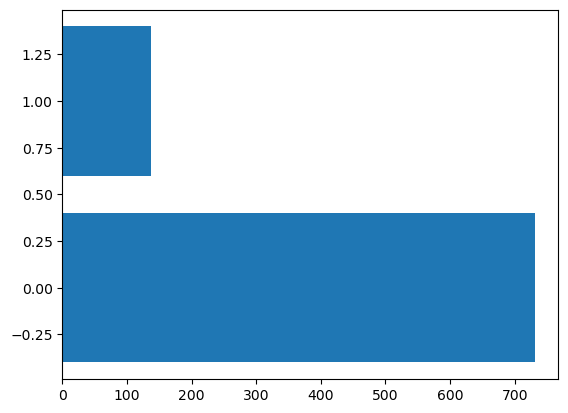

In [29]:
data2 = [12 * 60 + 11, 2 * 60 + 17]

plt.barh(range(len(data2)), data2)

plt.show() 

## Multi-process, Single-thread

In [13]:
from multiprocessing import Pool
from goTokyoMultiProcess import getAreaInfoProcess, testing, getAreaInfoProcessSingleLine

In [14]:
start = timer()
for place in placeAndUrlList[3:]:
    placeSize = len(place[2])
    logger.debug("place: {} len: {}", place[0], placeSize)
    if placeSize > 0:
        # Create pool of workers
        pool = Pool(placeSize)

        # Map pool of workers to process
        pool.starmap(func=getAreaInfoProcessSingleLine, iterable=place[2])

#         logger.debug("Process close")
#         pool.close()
        logger.debug("Process join")
#         pool.join(30)
        pool.wait(30)
        logger.debug("Sleep time")
        time.sleep(1)
    else:
        logger.debug("place: {} less or equal then 0, {}", place[0], placeSize)

end = timer()
logger.debug("Process take time {}", timedelta(seconds=end-start))

2022-12-11 01:38:58.394 | DEBUG    | __main__:<module>:4 - place: 도쿄서부 len: 12
2022-12-11 01:38:59.155 | DEBUG    | goTokyoMultiProcess:getAreaInfoProcessSingleLine:107 - Area crawling process start, areaName: 신주쿠, url: https://www.gotokyo.org/kr/destinations/western-tokyo/shinjuku/index.html
2022-12-11 01:38:59.155 | INFO     | goTokyoMultiProcess:getAreaInfoProcessSingleLine:111 - Setup headless browser options
2022-12-11 01:38:59.155 | DEBUG    | goTokyoMultiProcess:getAreaInfoProcessSingleLine:107 - Area crawling process start, areaName: 시부야, url: https://www.gotokyo.org/kr/destinations/western-tokyo/shibuya/index.html
2022-12-11 01:38:59.155 | INFO     | goTokyoMultiProcess:getAreaInfoProcessSingleLine:111 - Setup headless browser options
2022-12-11 01:38:59.159 | DEBUG    | goTokyoMultiProcess:getAreaInfoProcessSingleLine:107 - Area crawling process start, areaName: 하라주쿠, url: https://www.gotokyo.org/kr/destinations/western-tokyo/harajuku/index.html
2022-12-11 01:38:59.159 | INFO

2022-12-11 01:40:07.697 | DEBUG    | goTokyoMultiProcess:getSlideItems:27 - Slider item list len 1
2022-12-11 01:40:08.075 | DEBUG    | goTokyoMultiProcess:getAreaInfoProcessSingleLine:160 - Crawl slider items result [('쇼핑', [('Hillside Terrace', 'https://www.gotokyo.org/en/spot/547/images/547_0381_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/547/index.html'), ('다이칸야마의 참신한 패션 공간, 식물과 자연광이 만드는 완전히 아름다운 콜라보레이션을 체감', 'https://www.gotokyo.org/kr/new-and-now/new-and-trending/190624/images/190624_thum_400.jpg', 'https://www.gotokyo.org/kr/new-and-now/new-and-trending/190624/topics.html'), ('다이칸야마 쓰타야 서점 DAIKANYAMA T-SITE', 'https://www.gotokyo.org/_nopub/kr/20191031_065/images/new65_670x450.jpg', 'javascript:void(0);'), ('르라보 재팬', 'https://www.gotokyo.org/_nopub/en/spot/1316/images/1316_1286_1_670x450.jpg', 'javascript:void(0);'), ('헐리우드 랜치 마켓', 'https://www.gotokyo.org/_nopub/kr/spot/1613/images/1320_1_670x450.jpg', 'javascript:void(0);'), ('메종키츠네 다이칸야마', 'https://www.gotokyo.org/_nopub

2022-12-11 01:40:29.153 | DEBUG    | goTokyoMultiProcess:getSlideItems:27 - Slider item list len 6
2022-12-11 01:40:30.040 | INFO     | goTokyoMultiProcess:getAreaInfoProcessSingleLine:152 - Banner removed
2022-12-11 01:40:30.040 | INFO     | goTokyoMultiProcess:getAreaInfoProcessSingleLine:155 - Crawl slider items
2022-12-11 01:40:30.083 | DEBUG    | goTokyoMultiProcess:getSlideItems:27 - Slider item list len 2
2022-12-11 01:40:30.085 | DEBUG    | goTokyoMultiProcess:getSlideItems:27 - Slider item list len 4
2022-12-11 01:40:30.245 | DEBUG    | goTokyoMultiProcess:getSlideItems:27 - Slider item list len 2
2022-12-11 01:40:30.663 | DEBUG    | goTokyoMultiProcess:getSlideItems:27 - Slider item list len 3
2022-12-11 01:40:30.814 | DEBUG    | goTokyoMultiProcess:getSlideItems:27 - Slider item list len 3
2022-12-11 01:40:31.206 | DEBUG    | goTokyoMultiProcess:getSlideItems:27 - Slider item list len 1
2022-12-11 01:40:31.255 | DEBUG    | goTokyoMultiProcess:getAreaInfoProcessSingleLine:160

KeyboardInterrupt: 

In [ ]:
!echo $$